# Autoregression (AR)
## Covid-19 Canada Forecasting
Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

Two approaches: 

>Daily forecast: prediction of daily numbers (the following 28 daily numbers)

>Weekly forecast: prediction of weekly numbers directly (the following 4 weekly numbers)

>Note: A week is referred to 7 days StartDate - Date 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

In [3]:
def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    # get weekday column, weekday: Mon=1, Tue=2, ...., Sun=7
    d["weekday"] = d['Date'].dt.dayofweek + 1
    d = d.set_index(['CountryName', 'RegionCode', 'weekday', 'Date'])
    return d

In [4]:
# data load
d = load_OxCGRT()
# Canada data
d_CA = get_df(d, 'Canada')

In [5]:
# Recursive strategy for AR model
def ar_forecast(train, lookbacks, pred_steps):
    model = AutoReg(train, lags=lookbacks, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    history = train[len(train)-lookbacks:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for p in range(pred_steps):
        lag = [history[i] for i in range(len(history)-lookbacks,len(history))]
        yhat = coef[0]
        for d in range(lookbacks):
            yhat += coef[d+1] * lag[lookbacks-d-1]
        predictions.append(yhat[0])
        history.append(yhat)
        #print('predicted=%f'%(yhat))
    return predictions

## Daily Prediction

In [6]:
def daily_report(df, target_, predictions_, end_weekday, date_col, weekday, pred_steps):
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta(i+1) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target_: predictions_}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col, weekday])
    df_merge = df[[target_]].join(df_forecast[['Predicted'+target_]], how='outer')
    df_merge.index = df_merge.index.droplevel(['CountryName', 'RegionCode', 'weekday'])
    df_merge.plot(title = 'Daily New ' + target_, figsize=(8,3), lw=1, style = '.-')
    plt.show()
    df_forecast = df_forecast.cumsum()
    df_forecast = df_forecast[df_forecast.index.get_level_values(weekday) == end_weekday].fillna(0)
    first_week = df_forecast['Predicted'+target_].iloc[0]
    df_forecast = df_forecast.diff()
    df_forecast['Predicted'+target_].iloc[0] = first_week
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('Weekly New ' + target_ + ' (via Daily Prediction):\n')
    display(df_forecast.round(0).astype('int32'))


def daily_forecast(df, target, end_weekday = 5, date_col = 'Date', weekday = 'weekday', lookbacks = 28, pred_steps = 28):
    df = d_CA[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df.diff().fillna(0)
    print('Observations:\n')
    display(df)
    train = df.values
    predictions = ar_forecast(train, lookbacks, pred_steps)
    daily_report(df, target[0], predictions, end_weekday, date_col, weekday, pred_steps)

Observations:



Cases
CountryName RegionCode weekday Date              
Canada                 7       2020-01-26     0.0
                       1       2020-01-27     0.0
                       2       2020-01-28     1.0
                       3       2020-01-29     0.0
                       4       2020-01-30     0.0
...                                           ...
                       1       2021-03-01  3694.0
                       2       2021-03-02  2663.0
                       3       2021-03-03  2784.0
                       4       2021-03-04  2980.0
                       5       2021-03-05  2967.0

[405 rows x 1 columns]

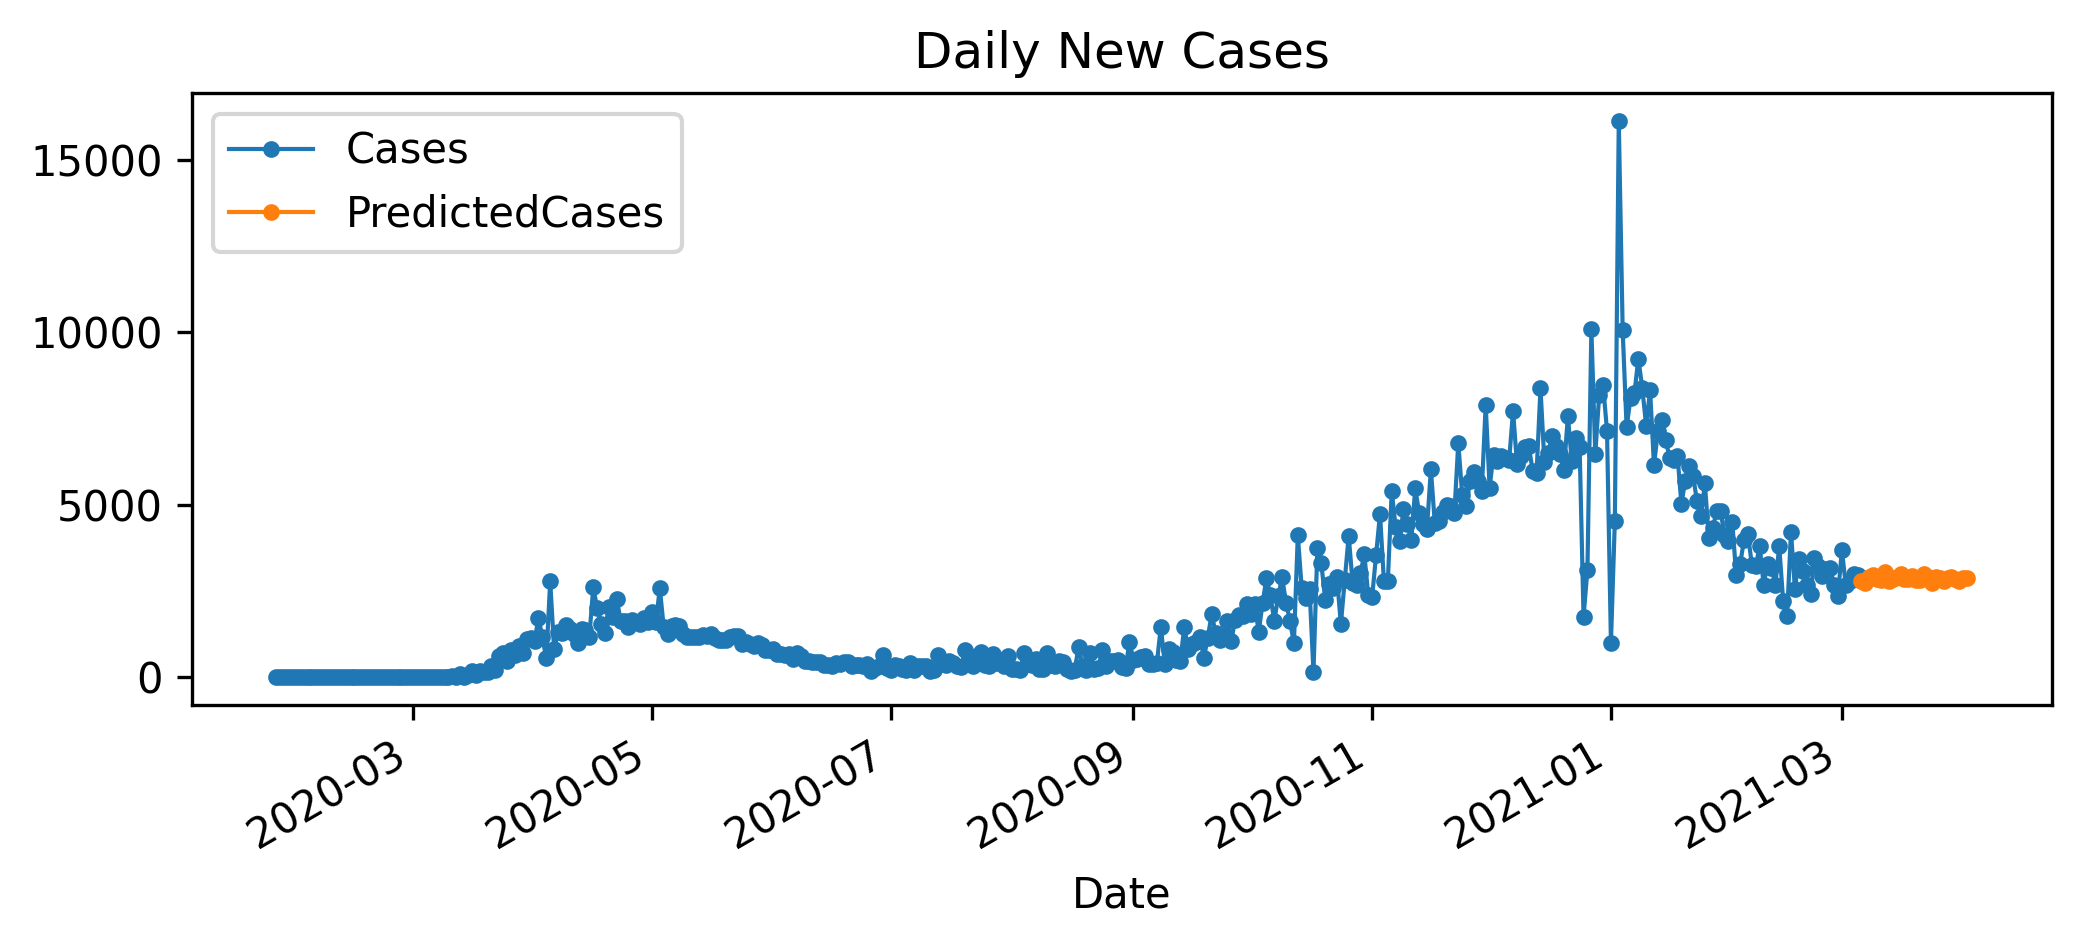

(StartDate through Date) Weekly New Cases (via Daily Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,20109
2021-03-19,5,2021-03-12,20153
2021-03-26,5,2021-03-19,19996
2021-04-02,5,2021-03-26,19941


In [7]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
daily_forecast(d_CA, ['Cases'], 5)

Observations:



Deaths
CountryName RegionCode weekday Date              
Canada                 1       2020-03-09     0.0
                       2       2020-03-10     0.0
                       3       2020-03-11     0.0
                       4       2020-03-12     0.0
                       5       2020-03-13     0.0
...                                           ...
                       1       2021-03-01    24.0
                       2       2021-03-02    29.0
                       3       2021-03-03    62.0
                       4       2021-03-04    47.0
                       5       2021-03-05    31.0

[362 rows x 1 columns]

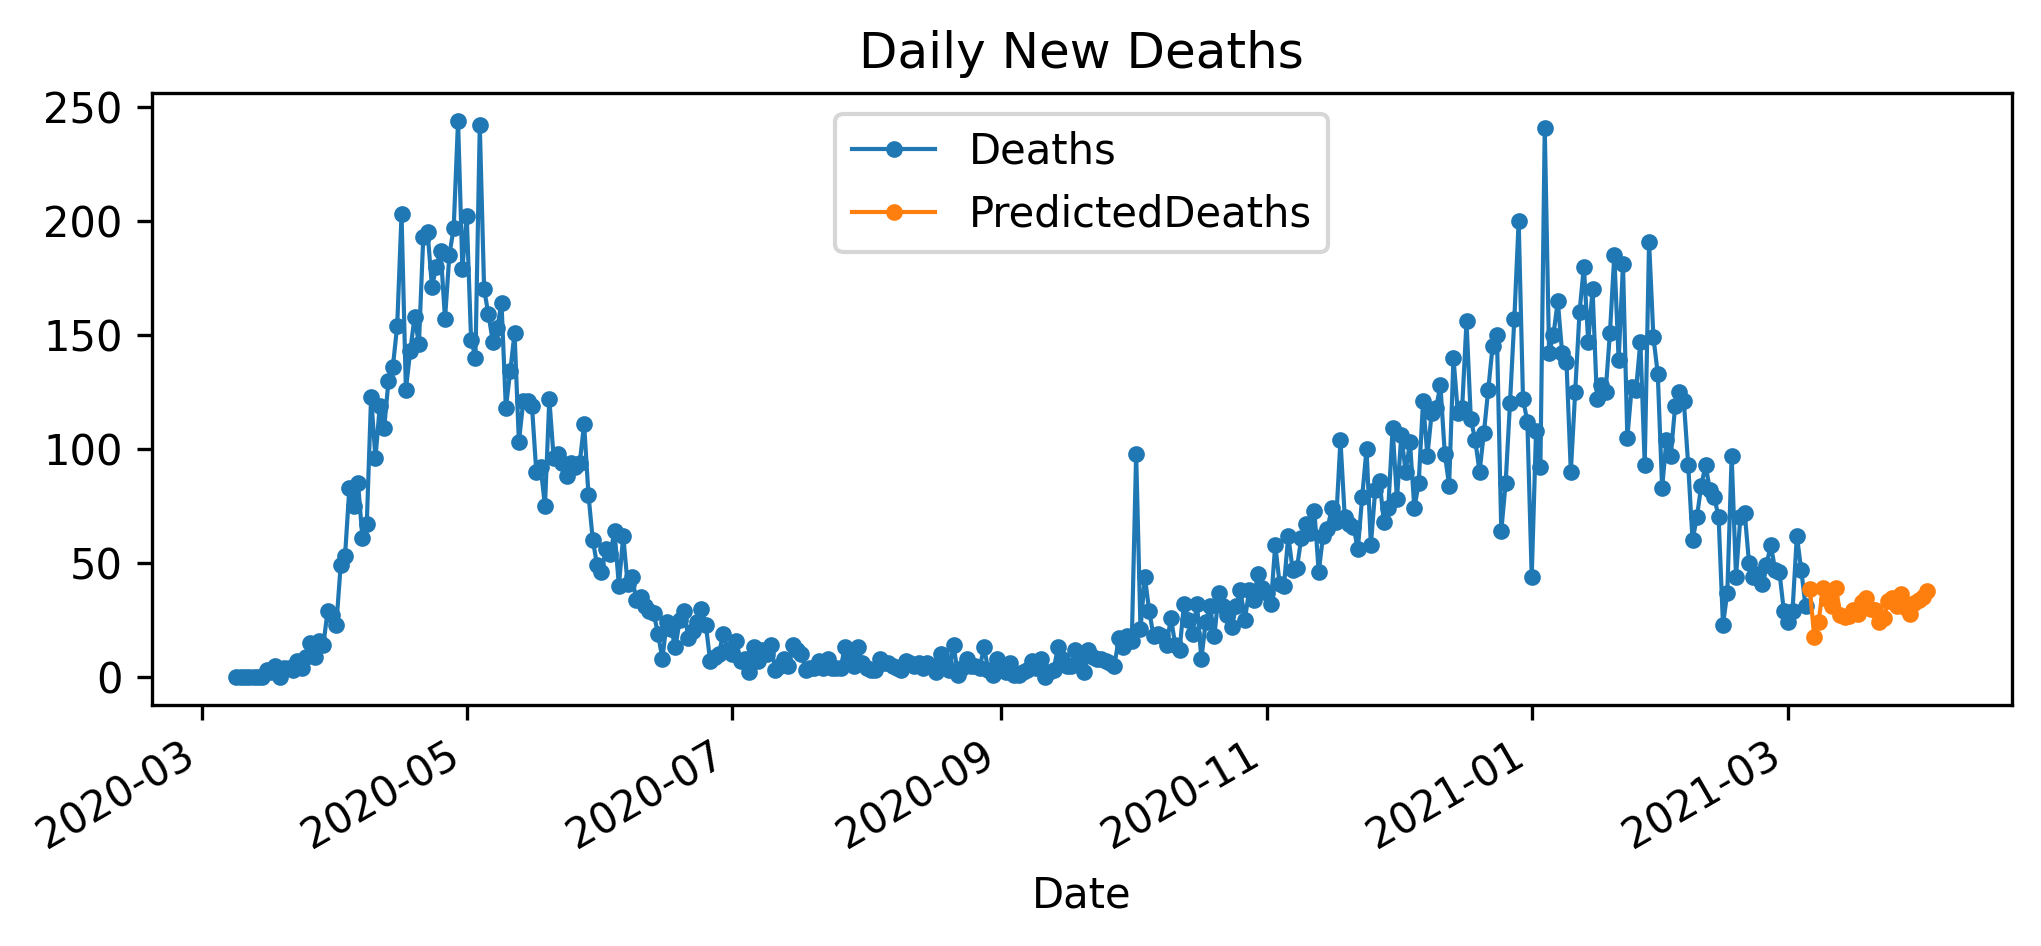

(StartDate through Date) Weekly New Deaths (via Daily Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,224
2021-03-19,5,2021-03-12,205
2021-03-26,5,2021-03-19,208
2021-04-02,5,2021-03-26,233


In [8]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
daily_forecast(d_CA, ['Deaths'], 5)

## Weekly Prediction

In [9]:
def weekly_forecast(target, end_weekday, date_col = 'Date', weekday = 'weekday', lookbacks = 4, pred_steps = 4, interval = 7):
    df = d_CA[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df[df.index.get_level_values(weekday) == end_weekday].fillna(0)
    df = df.diff().fillna(0)
    train = df.values
    predictions = ar_forecast(train, lookbacks, pred_steps)
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta((i+1)*interval) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target[0]: predictions}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col,weekday])
    df.index = df.index.droplevel(['CountryName', 'RegionCode'])
    df_merge = df.join(df_forecast, how='outer')
    df_merge.index = df_merge.index.droplevel(['weekday'])
    df_merge.plot(title = 'AR Model: Weekly New ' + target[0], figsize=(8,3), lw=1)
    plt.show()
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('(StartDate through Date) Weekly New ' + target[0] + ' (via Weekly Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

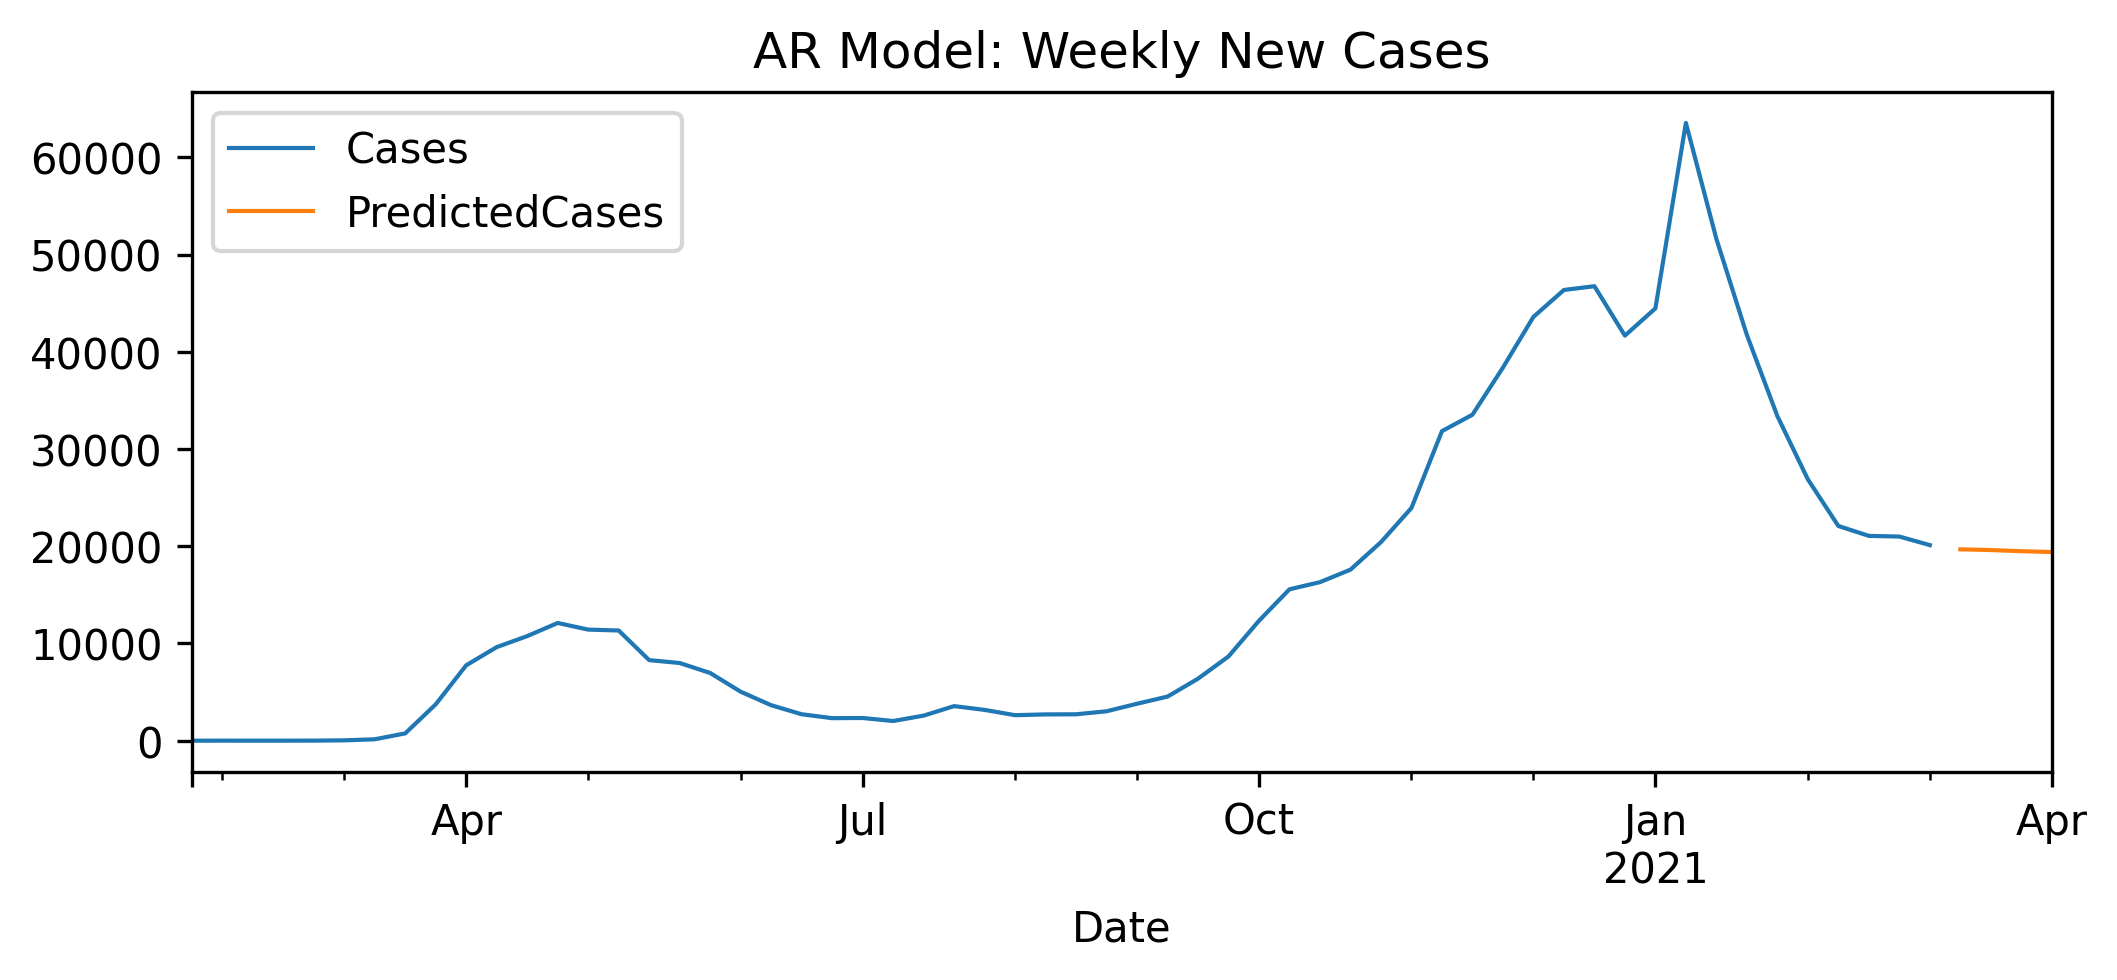

(StartDate through Date) Weekly New Cases (via Weekly Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,19678
2021-03-19,5,2021-03-12,19607
2021-03-26,5,2021-03-19,19485
2021-04-02,5,2021-03-26,19404


In [10]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
weekly_forecast(['Cases'], 5)

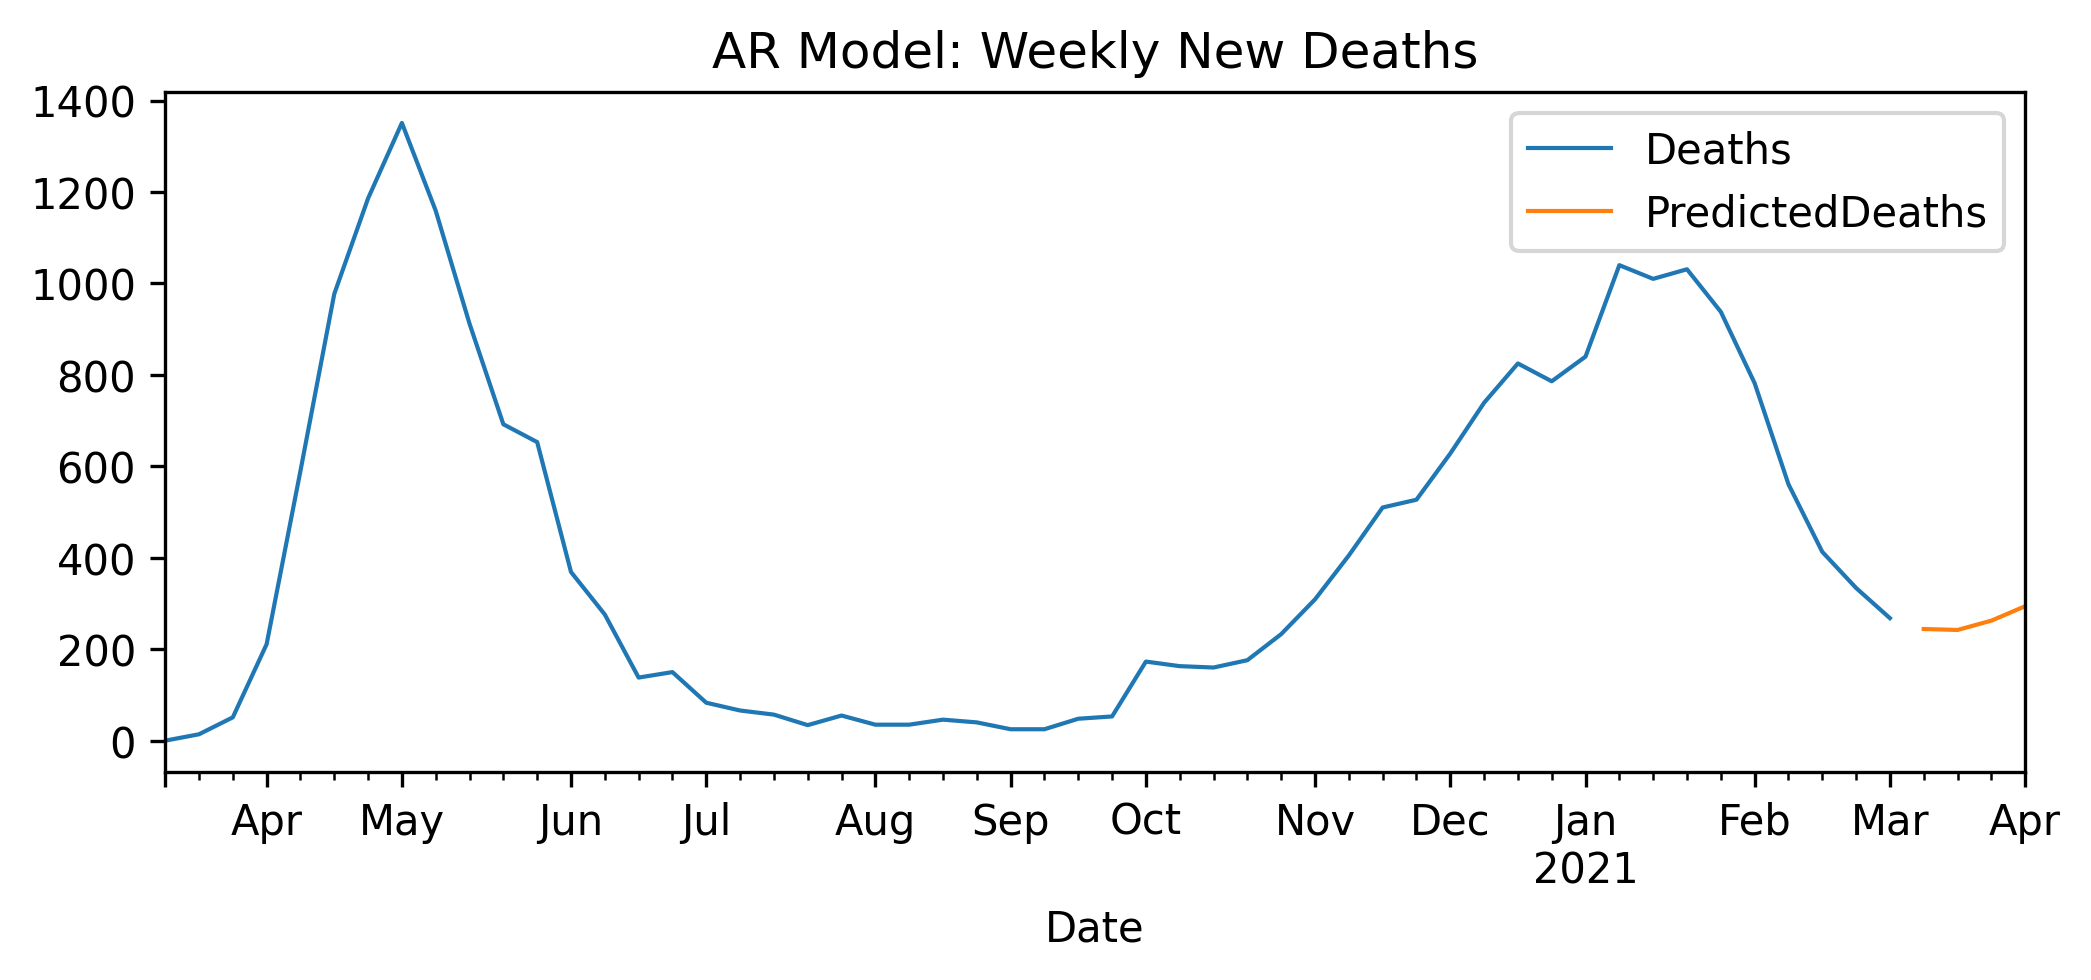

(StartDate through Date) Weekly New Deaths (via Weekly Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,244
2021-03-19,5,2021-03-12,242
2021-03-26,5,2021-03-19,262
2021-04-02,5,2021-03-26,294


In [11]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
weekly_forecast(['Deaths'], 5)